#### Image preprocessing

torch.Size([256, 256])


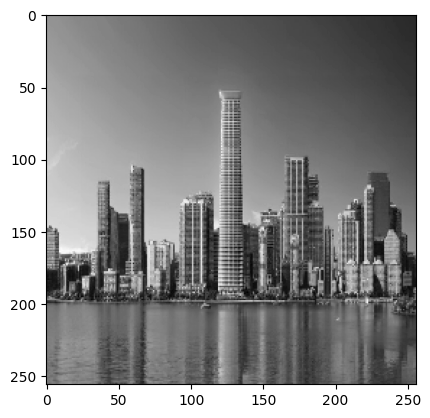

In [81]:
import torch
import cv2
import matplotlib.pyplot as plt

path = 'sm-unsplash.jpg'
path = 'testimage.jpg'

def preprocess_img(path, resize=256):
    img = cv2.imread(path)
    img = cv2.resize(img, (resize, resize))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)     #convert to grayscale
    img = torch.tensor(img, dtype=torch.float32) / 255.0                               #normalize

    return img

img = preprocess_img(path)
print(img.shape)
plt.imshow(img, cmap='gray')

#### Calculate gradients

tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]]) torch.Size([1, 1, 3, 3])


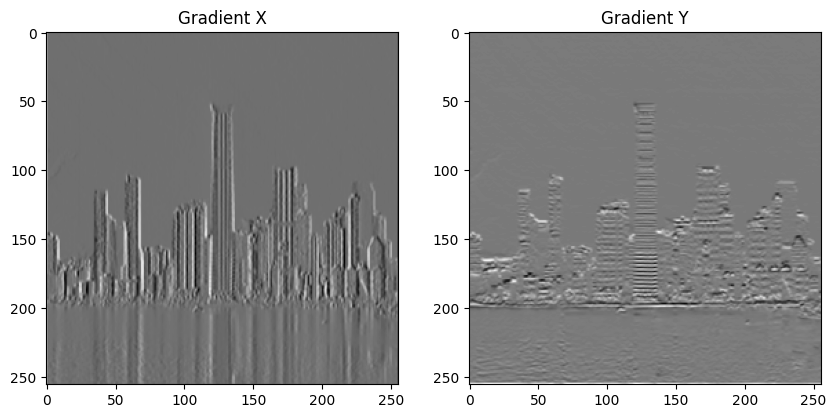

In [82]:
## Sobel filters for gradient computation
## sobel_x captures the horizontal gradient which is used to detect vertical edges in the image, while sobel_y captures the vertical gradient which is used to detect horizontal edges

sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)   # add 2 dimensions for batch and channel
sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

print(sobel_x, sobel_x.shape)

## Gradient computation is a convolution operation
## The gradient is calculated in both x and y directions

def comp_grads(img):
    img = img.unsqueeze(0).unsqueeze(0)  # add batch and channel dimensions
    grad_x = torch.nn.functional.conv2d(img, sobel_x, padding=1)
    grad_y = torch.nn.functional.conv2d(img, sobel_y, padding=1)

    return grad_x.squeeze(), grad_y.squeeze()   # remove batch and channel dimensions

gx, gy = comp_grads(img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gx, cmap="gray")
plt.title("Gradient X")
plt.subplot(1, 2, 2)
plt.imshow(gy, cmap="gray")
plt.title("Gradient Y")
plt.show()

#### Magnitude and orientation calculation


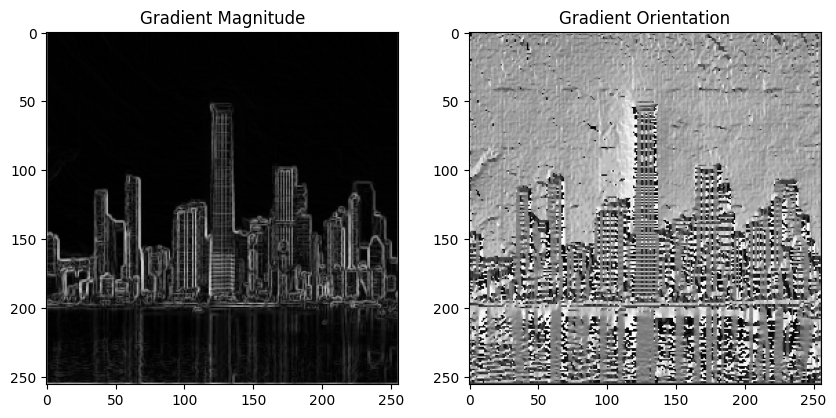

In [83]:
def compute_mag_orient(gx, gy):
    mag = torch.sqrt(gx**2 + gy**2)
    orient = torch.atan2(gy, gx)        # returns angle in radians between -pi/2 and pi/2
    orient = torch.rad2deg(orient)      # convert to degrees
    orient = (orient + 360) % 360       # convert to range 0 to 360

    return mag, orient

magnitude, orientation = compute_mag_orient(gx, gy)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(magnitude.numpy(), cmap="gray")
plt.title("Gradient Magnitude")
plt.subplot(1, 2, 2)
plt.imshow(orientation.numpy(), cmap="gray")
plt.title("Gradient Orientation")
plt.show()

#### Image to cells

In [84]:
cell_size = 8

def div_cells(mag, orient, cell_size):
    row, col = mag.shape
    cells = []
    for i in range(0, row, cell_size):
        for j in range(0, col, cell_size):
            cell_m = mag[i:i+cell_size, j:j+cell_size]
            cell_o = orient[i:i+cell_size, j:j+cell_size]
            cells.append((cell_m, cell_o))
    
    return cells

cells = div_cells(magnitude, orientation, cell_size)
print("number of cells:", len(cells))

number of cells: 1024


#### Compute HOG

In [85]:
def compute_hog(mag, orient, num_bins=9):
    bin_ticks = torch.linspace(0, 360, num_bins+1)
    hist = torch.zeros(num_bins)

    for m, o in zip(mag.flatten(), orient.flatten()):
        for b in range(num_bins):
            if bin_ticks[b] <= o < bin_ticks[b+1]:
                hist[b] += m
                break
    
    return hist

mc1, oc1 = cells[0]   # first cell
hist = compute_hog(mc1, oc1)
print("Histogram", hist)

Histogram tensor([9.4902e+00, 0.0000e+00, 0.0000e+00, 5.5459e-03, 2.9899e-01, 2.7962e-01,
        1.6505e+01, 2.5247e+00, 7.1413e+00])


#### Normalize Histogram

In [86]:
def normalize_blocks(cells, cell_size=8, block_size=2, num_bins=9):
    x_cells = int(magnitude.shape[0] / cell_size)
    y_cells = int(magnitude.shape[1] / cell_size)

    hog_features = []

    for i in range(x_cells - block_size + 1):
        for j in range(y_cells - block_size + 1):
            block_vector = []
            for k in range(block_size):
                for l in range(block_size):
                    cell_index = (i+k) * y_cells + (j+l)
                    cell_m, cell_o = cells[cell_index]
                    block_vector.append(compute_hog(cell_m, cell_o))
            
            block_vector = torch.cat(block_vector)
            block_vector = block_vector / torch.norm(block_vector + 1e-6)   # L2 normalization
            hog_features.append(block_vector)
    
    
    return torch.cat(hog_features)

hog_features = normalize_blocks(cells, cell_size)
print("HOG feature vector size:", hog_features.shape)

HOG feature vector size: torch.Size([34596])


#### Visualizing HOG features

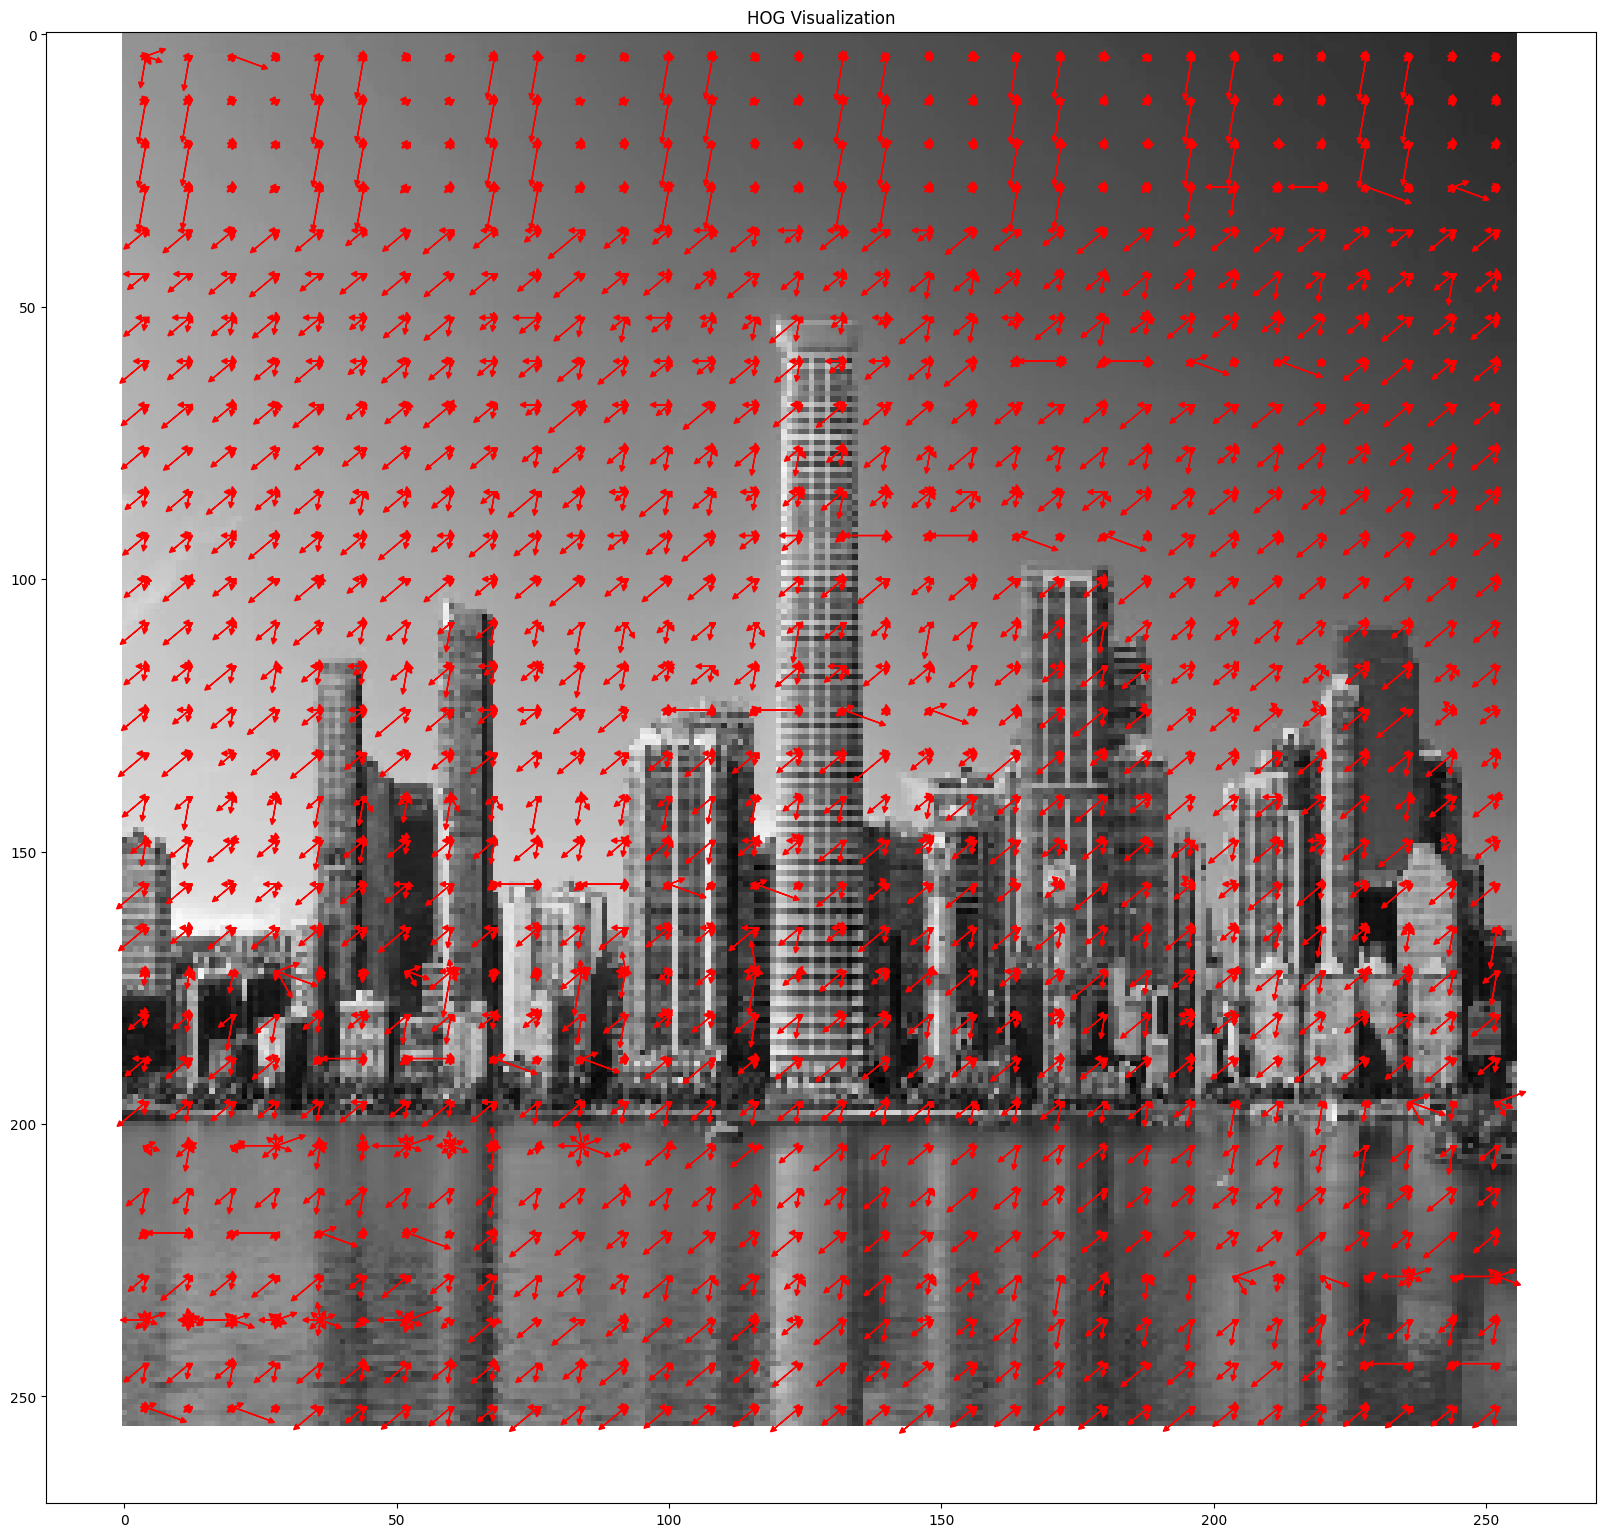

In [87]:
# Function to visualize the HOG features
def visualize_hog(image, cells, hog_features, cell_size, num_bins=9):
    h, w = image.shape
    bin_edges = torch.linspace(0, 360, num_bins+1)  # Create num_bins edges (0 to 360, excluding 360)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

    plt.figure(figsize=(20, 20)) 
    plt.imshow(image.numpy(), cmap="gray")
    
    # Loop through each cell and draw gradient arrows based on histogram values
    cell_idx = 0
    for i in range(0, h, cell_size):
        for j in range(0, w, cell_size):
            cell_magnitude, cell_orientation = cells[cell_idx]
            hist = hog_features[cell_idx * num_bins:(cell_idx + 1) * num_bins]
            
            # Get the angle and magnitude for each orientation bin
            for bin_idx, mag in enumerate(hist):
                angle = bin_centers[bin_idx]
                # Convert angle to radians for vector representation
                angle_rad = torch.deg2rad(angle)
                dx = mag * torch.cos(angle_rad).item() * 10 # X component of the vector multiplied by a scalar for better visualization
                dy = mag * torch.sin(angle_rad).item() * 10 # Y component of the vector multiplied by a scalar for better visualization
                
                # Draw arrows indicating the direction of gradients
                plt.arrow(j + cell_size // 2, i + cell_size // 2, dx, -dy,
                          color="red", head_width=1, head_length=1, fc='red', ec='red')

            cell_idx += 1

    plt.title("HOG Visualization")
    plt.show()

visualize_hog(img, cells, hog_features, cell_size=8)

Every cell is divided into nine bins, that's why 9 arrows are appearing on the visualization. Each arrow's direction corresponds to a specific orientation bin. The length of arrow corresponds to the magnitude. This tells us how the gradients are distributed within the cell.

Regions with strong edges or textures will have higher gradient magnitudes in certain directions. For example, in an image of vertical stripes, the bins corresponding to 90° and 270° will have higher magnitudes because the gradients align with those orientations.


HOG features are widely used in image recognition tasks (e.g., object detection) because they capture local edge information and the distribution of orientations, which are invariant to changes in lighting or contrast.

#### Why Grayscale?

Grayscale images are simpler to work with. They have only one channel, which makes them easier to process and reduces computational cost.ConnectionResetError

HOG captures the edges of the image, which are the most important features for object detection. These edges are usually present in the grayscale image. 
So, converting the image to grayscale will not affect the performance of the HOG detector.

#### When to use color images?
Special cases where color is important.
For example, in the case of detecting traffic lights, the color of the light is important.


#### Why Sobel filter?

Sobel filter is used to calculate the gradient of the image intensity. It is used to detect edges in the image. 
It is computationally efficient and easy to implement.
Works well for most edge detection tasks by balancing noise suppression and edge sharpness.

#### Citation

Photo by [Saurav Mahto](https://unsplash.com/@sauravmahto?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash) on [Unsplash](https://unsplash.com/photos/white-concrete-building-under-blue-sky-during-daytime-_q28qN7J7Sg?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash)

Photo from https://www.archdaily.com/tag/mixed-use-tower
